# Audio Transformer

In [1]:
import os
import shutil
import  joblib
import numpy as np
import pandas as pd
import librosa as lb
import librosa.display
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.notebook import tqdm

In [16]:
DATA_ROOT = Path("../input/rfcx-species-audio-detection")
TRAIN_AUDIO_ROOT = Path("../input/rfcx-species-audio-detection/train")
TEST_AUDIO_ROOT = Path("../input/rfcx-species-audio-detection/test")
OUT_TRAIN = Path("../input/rfcx-species-audio-detection/test")
OUT_TSA = Path("../input/rfcx-species-audio-detection/test")

In [3]:
df_train = pd.DataFrame({
    "recording_id": [path.stem for path in Path(TRAIN_AUDIO_ROOT).glob("*.flac")],
})

df_test = pd.DataFrame({
    "recording_id": [path.stem for path in Path(TEST_AUDIO_ROOT).glob("*.flac")],
})

In [4]:
class params:
    """
    Parameters used for the audio data
    """
    sr = 32000

    # Melspectrogram
    n_mels = 128
    fmin = 20
    fmax = sr // 2  # Shannon theorem

In [5]:
def load_audio(record, sr=16000, root=""):
    y, _ = lb.load(
        root.joinpath(record).with_suffix(".flac").as_posix(),
        sr=sr, 
    )
    return y

In [6]:
def compute_melspec(y, params):
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
        np array -- Mel-spectrogram
    """
    melspec = lb.feature.melspectrogram(
        y, sr=params.sr, n_mels=params.n_mels, fmin=params.fmin, fmax=params.fmax,
    )

    melspec = lb.power_to_db(melspec).astype(np.float32)
    return melspec

In [7]:
y = load_audio(df_train["recording_id"][0], params.sr, TRAIN_AUDIO_ROOT)

In [8]:
melspec = compute_melspec(y, params)

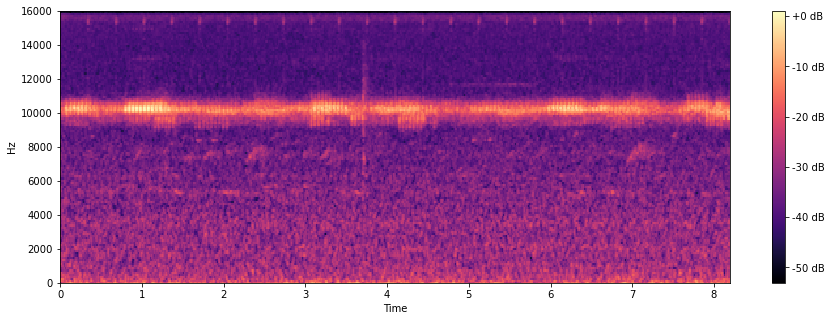

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
img = librosa.display.specshow(
    melspec[:, :512], 
    sr=params.sr,
    x_axis='time', 
    y_axis='linear', 
    ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.show()

In [10]:
np.save("melspec.npy", melspec)

In [11]:
%%timeit 
spec = np.load("melspec.npy")

797 µs ± 22.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
%%timeit 
y = load_audio(df_train["recording_id"][0], params.sr, TRAIN_AUDIO_ROOT)
melspec = compute_melspec(y, params)

1.7 s ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Train

In [20]:
def load_and_save_train(record):
    y = load_audio(record, params.sr, TRAIN_AUDIO_ROOT)
    melspec = compute_melspec(y, params)

    np.save(os.path.join(OUT_TRAIN, record + ".npy"), melspec)

In [25]:
_ = joblib.Parallel(n_jobs=8)(
    joblib.delayed(load_and_save_train)(record) for record in tqdm(df_train['recording_id'].values)
)

## Test

In [26]:
def load_and_save_test(record):
    y = load_audio(record, params.sr, TEST_AUDIO_ROOT)
    melspec = compute_melspec(y, params)

    np.save(os.path.join(OUT_TEST, record + ".npy"), melspec)

In [27]:
_ = joblib.Parallel(n_jobs=8)(
    joblib.delayed(load_and_save_test)(record) for record in tqdm(df_test['recording_id'].values)
)

In [ ]:
# shutil.make_archive(OUT_TEST, 'zip', OUT_TEST)
# shutil.rmtree(OUT_TEST)